In [1]:
import pandas as pd
import numpy as np
from matplotlib.image import imsave
from PIL import Image, ImageDraw
import os

import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# - FUNCTIONS

In [2]:
def remove_negative_coord(array, liste):
    
    array_max = array.shape[0]
    
    liste_without_negative = []
    
    for element in liste:
        if element[0] >= 0 and element[1] >= 0 and element[0] < array_max and element[1] < array_max:
            liste_without_negative.append(element)
            
    return liste_without_negative

In [3]:
def flatten_list_of_list(liste):
    return [item for sublist in liste for item in sublist]

In [4]:
def set_new_patient(array, liste_coord):

    for coord in liste_coord:
        array[coord[0], coord[1]] =1
    
    return array

In [5]:
def neighbors(array, coord, radius=1):
    all_neighbors_coord = []
    
    lst_coord = range(-radius, radius+1)
    
    for x in lst_coord:
        for y in lst_coord:
            if (x != coord[0]) or (y != coord[1]):
                all_neighbors_coord.append([coord[0] + x,coord[1] + y])
                
    all_neighbors_coord = remove_negative_coord(array, all_neighbors_coord)
                
    return all_neighbors_coord

In [6]:
def contamination_qty(liste, percent):

    if percent != 0 :
        n = 100//percent
        return random.sample(liste, len(liste)//n)
    else:
        return liste

In [7]:
def remove_old_patient(array, liste_coord):
    
    liste_coord = flatten_list_of_list(liste_coord)
    
    for coord in liste_coord:
        array[coord[0], coord[1]] = 0
    
    return array

In [8]:
def remove_vacc_patient(array, liste_coord):
    
    for coord in liste_coord:
        array[coord[0], coord[1]] = 0
    
    return array
    

In [9]:
def make_gif(folder):
    
    gif = []

    liste_image = [nom_image for nom_image in os.listdir(folder) if nom_image.endswith('.jpg')]

    for image_path in liste_image:
        image = Image.open(os.path.join(folder,image_path))
        gif.append(image)
    
    gifname = os.path.join(folder, 'gif.gif')
    gif[0].save(gifname, save_all=True, append_images=gif[1:], optimize=False, duration=99, loop=0)


In [10]:
def plot_distribution(df, list_col_to_plot):

    if len(list_col_to_plot) > 3:
        nrows = len(list_col_to_plot)//3 + 1
        ncols = 3
    else:
        nrows = 1
        ncols = len(list_col_to_plot)

    plt.figure(figsize=(ncols*7,nrows*5))

    for i_sensor, sensor in enumerate(list_col_to_plot):

        plt.subplot(nrows, ncols, i_sensor+1) 
        plt.hist(df[sensor], bins = 10)
        plt.title(sensor)
        
    plt.show()

In [11]:
def generate_population(pop_size=500, patient_0=None, vacc=0):
    
    pop = np.zeros((pop_size,pop_size), dtype=int)
    
    # set patient 0
    if patient_0:
        patient_0_x = patient_0[0]
        patient_0_y = patient_0[1]
    else:
        patient_0_x = np.random.randint(pop_size)
        patient_0_y = np.random.randint(pop_size)
            
    pop[patient_0_x][patient_0_y] = 1

    vacc = np.random.choice([0, 1], size=pop_size*pop_size, p=[1-vacc, vacc]).astype(int)
    vacc = np.reshape(vacc, (pop_size, pop_size))
    loc_vacc = np.transpose(np.where(vacc==1))
    
    print('{}/{} personnes sont vaccinés, soit {} %'.format(len(loc_vacc), pop_size, (len(loc_vacc)*100/pop_size)))
    
    return pop, loc_vacc

In [57]:
def iterate_contamination(pop, loc_vacc, vacc, neighbors_infected_divided=2, iteration=200):
    
    save = []
    
    workdir = 'C:\\Users\\Raphaël\\Jupyter\\flu_model\\'
    folder = os.path.join(workdir, 'images/vacc_{}_neighbors_infected_{}'.format(vacc, neighbors_infected_divided))
#     folder = os.path.join(workdir, 'images/vacc_{}_neighbors_infected_random'.format(vacc))
    os.makedirs(folder, exist_ok=True)
    print('sauvegarde dans le dossier {}'.format(folder))
    
    old_patient = []
#     df = pd.DataFrame({'nb_infected_random_qty'.format(neighbors_infected_divided):[0]*(iteration+1)})
    df = pd.DataFrame({'vacc_{}_nb_infected_{:02d}_qty'.format(vacc, neighbors_infected_divided):[0]*(iteration+1)})
    pop_without_old_patient = pop
    
    imsave('{}/conta_000.jpg'.format(folder), pop, cmap='binary')


    for i in range(iteration):

        all_new_contaminated = []
        location_patient = np.transpose(np.where(pop==1))

        for location in location_patient:
            

            radius = random.sample([1,2],1)[0]
            save.append(neighbors_infected_divided)

            local_new_patient = neighbors(pop, location, radius=radius)
            local_new_patient = random.sample(local_new_patient, len(local_new_patient)//neighbors_infected_divided)

            all_new_contaminated.append(local_new_patient)
        all_new_contaminated = flatten_list_of_list(all_new_contaminated)
        pop = set_new_patient(pop, all_new_contaminated)
        old_patient.append(location_patient)
        pop = remove_vacc_patient(pop, loc_vacc)
        pop_without_old_patient = remove_old_patient(pop, old_patient)
        
        nb_infected = len(np.where(pop_without_old_patient==1)[0])
        df.loc[i+1, 'vacc_{}_nb_infected_{:02d}_qty'.format(vacc, neighbors_infected_divided)] = nb_infected
#         df.loc[i+1, 'nb_infected_random_qty'] = nb_infected

        imsave('{}/conta_{:03d}.jpg'.format(folder, i+1), pop_without_old_patient, cmap='binary')

    make_gif(folder)
    
    df['vacc_{}_nb_infected_{:02d}_sum'.format(vacc,neighbors_infected_divided)] = df['vacc_{}_nb_infected_{:02d}_qty'.format(vacc,neighbors_infected_divided)].cumsum()
#     df['nb_infected_random_sum'] = df['nb_infected_random_qty'].cumsum()
    df.to_csv(os.path.join(folder, 'nb_infected.csv'), sep=';', index=False)
    
    return save

# - Generate contamination

In [58]:
pop_size=500
patient_0 = [250,250]
iteration=200
vacc=0

for score in range(1,11):

    pop, loc_vacc = generate_population(pop_size=pop_size, patient_0=patient_0, vacc=vacc)  
    distrib = iterate_contamination(pop, loc_vacc, vacc=vacc, neighbors_infected_divided=score, iteration=iteration)

0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_1
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_2
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_3
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_4
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_5
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_6
0/500 personnes sont vaccinés, soit 0.0 %
sauvegarde dans le dossier C:\Users\Raphaël\Jupyter\flu_model\images/vacc_0_neighbors_infected_7
0/500 personnes sont vaccin

In [233]:
# df = pd.DataFrame({'Distribution des scores':distrib})

# plot_distribution(df, ["Distribution des scores"])

In [59]:
workdir='C:\\Users\\Raphaël\\Jupyter\\flu_model\\images\\'
liste_folder = [folder for folder in os.listdir(workdir)]

pdf = pd.DataFrame(index = range(201))

for folder in liste_folder:
    file = os.path.join(workdir, folder, 'nb_infected.csv')
    
    df = pd.read_csv(file, sep=';')
    
    pdf = pdf.merge(df, left_index=True, right_index=True)

In [60]:
pdf

,vacc_0_nb_infected_01_qty,vacc_0_nb_infected_01_sum,vacc_0_nb_infected_10_qty,vacc_0_nb_infected_10_sum,vacc_0_nb_infected_02_qty,vacc_0_nb_infected_02_sum,vacc_0_nb_infected_03_qty,vacc_0_nb_infected_03_sum,vacc_0_nb_infected_04_qty,vacc_0_nb_infected_04_sum,vacc_0_nb_infected_05_qty,vacc_0_nb_infected_05_sum,vacc_0_nb_infected_06_qty,vacc_0_nb_infected_06_sum,vacc_0_nb_infected_07_qty,vacc_0_nb_infected_07_sum,vacc_0_nb_infected_08_qty,vacc_0_nb_infected_08_sum,vacc_0_nb_infected_09_qty,vacc_0_nb_infected_09_sum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,8,2,2,4,4,7,7,1,1,5,5,3,3,1,1,1,1,1,1
2,35,43,2,4,19,23,26,33,1,2,21,26,6,9,1,2,2,3,0,1
3,54,97,2,6,56,79,49,82,6,8,36,62,11,20,1,3,2,5,0,1
4,78,175,2,8,80,159,64,146,18,26,48,110,16,36,1,4,1,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,249999,0,14,0,249959,0,249281,144,244931,737,224701,1264,188919,915,68968,1089,93481,0,1
197,0,249999,0,14,0,249959,0,249281,106,245037,697,225398,1229,190148,884,69852,1139,94620,0,1
198,0,249999,0,14,0,249959,0,249281,98,245135,662,226060,1146,191294,925,70777,1124,95744,0,1
199,0,249999,0,14,0,249959,0,249281,87,245222,641,226701,1108,192402,912,71689,1111,96855,0,1


In [61]:
pdf = pdf.reindex(sorted(pdf.columns), axis=1)
pdf_sum = pdf.filter(regex='sum')
pdf_ = pdf.filter(regex='qty')

In [62]:
pdf_

,vacc_0_nb_infected_01_qty,vacc_0_nb_infected_02_qty,vacc_0_nb_infected_03_qty,vacc_0_nb_infected_04_qty,vacc_0_nb_infected_05_qty,vacc_0_nb_infected_06_qty,vacc_0_nb_infected_07_qty,vacc_0_nb_infected_08_qty,vacc_0_nb_infected_09_qty,vacc_0_nb_infected_10_qty
0,0,0,0,0,0,0,0,0,0,0
1,8,4,7,1,5,3,1,1,1,2
2,35,19,26,1,21,6,1,2,0,2
3,54,56,49,6,36,11,1,2,0,2
4,78,80,64,18,48,16,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...
196,0,0,0,144,737,1264,915,1089,0,0
197,0,0,0,106,697,1229,884,1139,0,0
198,0,0,0,98,662,1146,925,1124,0,0
199,0,0,0,87,641,1108,912,1111,0,0


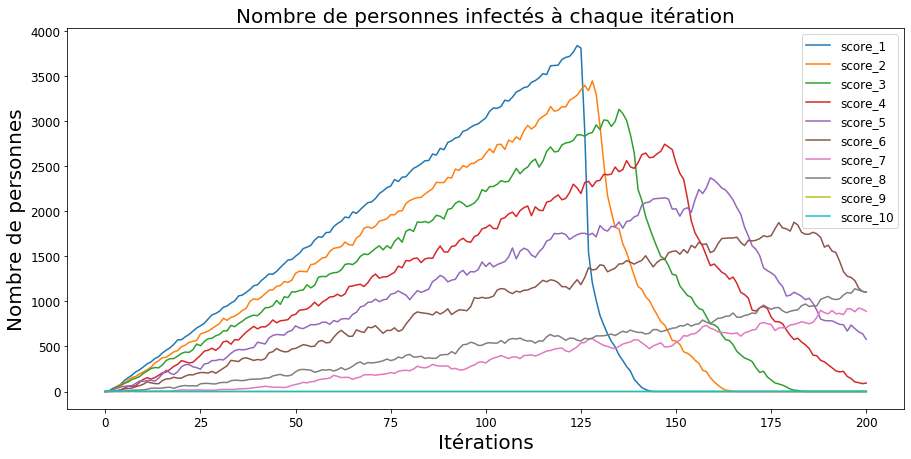

In [67]:
plt.figure(figsize=(15,7))
for i_col, col in enumerate(pdf_):
    plt.title('Nombre de personnes infectés à chaque itération', fontsize=20)
    plt.plot(pdf[col], label='score_{}'.format(i_col+1))
    plt.xlabel('Itérations', fontsize=20)
    plt.ylabel('Nombre de personnes', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
plt.savefig('random_radius_1_2_all_score.jpg')


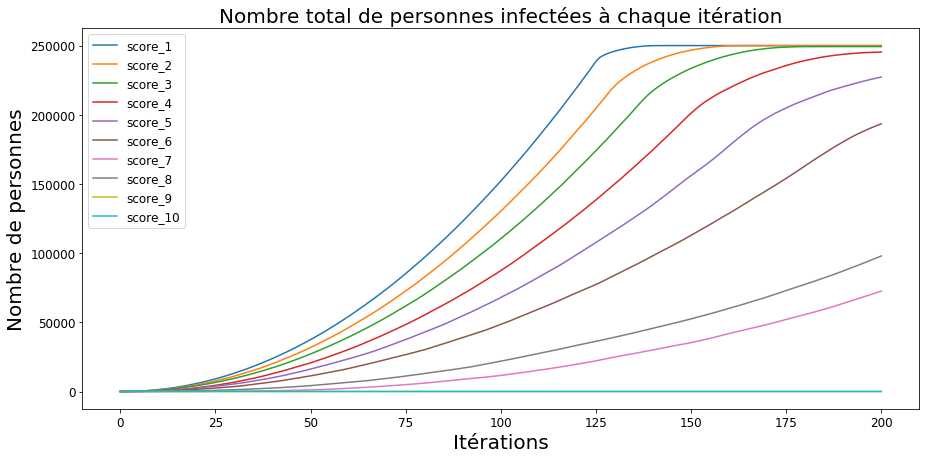

In [68]:
plt.figure(figsize=(15,7))
for i_col, col in enumerate(pdf_sum):
    plt.title('Nombre total de personnes infectées à chaque itération', fontsize=20)
    plt.plot(pdf[col], label='score_{}'.format(i_col+1))
    plt.xlabel('Itérations', fontsize=20)
    plt.ylabel('Nombre de personnes', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
plt.savefig('random_radius_1_2_all_score_sum.jpg')

In [15]:
test=None

In [17]:
if not test:
    print('k')

k
